In this workbook, I have built a lagistic regression model to classify the sentiment from feedback text. 
The Sentiment is either 0 or 1 
where 0 is not happy
and 1 is happy 

At the end, I take 5 random misclassified examples to analysis the performance of the logistic regression model

### Loading and Prep



In [ ]:
# Import the relevant libraries
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
import spacy
nltk.download('stopwords')
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import ngrams

df_train = pd.read_csv("sentiment_train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("sentiment_test.csv")

print(df_test.info())
print(df_test.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sent

**Preprocessing of the text**

Step 1) Text Cleaning:
- Normalizing all the words to lower (Why? So that model doesn't treat "Great" or "great" differently)
- Removing stop words (Why? Some prevalent words such as 'the', 'is' doesn't add any value)
- Lemmetization (Why? Returns the root form of a word and thus helping the model treat words such as "Liked" and "Like" as same)

Step 2) Feature extraction:
- TF-IDF extraction (term frequency inverse document frequency) - This extraction technique will return a bag of words matrix for words and n-grams. The matrix will have the columns as the words and n-grams, while the values will be each word's tfidf value.
- TF-IDF is a better feature extraction method in our case as by taking into account the frequency of the word across the all documents it can reduce the weight of prevalent words while increasing the weight of less frequent but important words.

In [ ]:
###########************************** Proprocessing of text *************************#################


nlp = spacy.load('en', disable=['parser', 'ner'])
# Stopwords updated list - These negation words will help model learn the negative sentiment 
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("not", "no", "against","mustn't","needn't","shouldn't","won't", "wouldn't"))
new_stop_words = stop_words.difference(exclude_words)
 
################################### Step 1- Clean the Sentence ########################################
def clean_data(text):
    punct = "".join([word.lower() for word in text if word not in string.punctuation])
    txt = re.split('\W+',punct)    
    doc = nlp(" ".join(txt))
    return " ".join([token.lemma_ for token in doc])

df_train["clean_sentence"] = df_train.Sentence.apply(clean_data)


################################## Step 2 - Feature Extraction using TF-IDF ############################
vectorizer = TfidfVectorizer(
                             stop_words = new_stop_words,
                             max_df = 0.4, 
                             min_df=2,
                             max_features = 2000,
                             ngram_range=[1,3])
def fit_features(df):
  global dtm
  dtm = vectorizer.fit(df)
  return

def transform_features(df):
  global dtm
 
  if dtm is None:
    print("Need to call fit_features first!")
    return

  dtm = vectorizer.transform(df)

  features = pd.DataFrame(dtm.toarray(), 
                      columns=[f'{name}' for name in 
                               vectorizer.get_feature_names()], 
                      index=df.index)
  
  return features

X_train,y_train = df_train.loc[:,"clean_sentence"], df_train.loc[:,"Polarity"]
fit_features(X_train)
X_train_features = transform_features(X_train)

### Modeling

Using my favourite ML model Logistic Regression



**Importing all the relevant modules**

In [ ]:
##### Importing the relevant packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

**Model Training with hyperparamter tuning**

- Hyperparameter tuning:

Two hyperparameters are tuned 
1) class_weight - 'Balance' or 'None'
2) C - Regularization parameter




- Cross validation:

Cross validation is done using 3 fold 




- Handled imbalanced data:

Data imbalance handled by tuning 'class_weight' parameter



- Features scaled:

Features are scaled using MinMaxScaler (range 0-1).
Scaling the features help Logistic regression in convergence

In [ ]:
pipeline = Pipeline([('scaler', MinMaxScaler()), 
                    ('LR', LogisticRegression(random_state=21))])

param_grid = {
                "LR__class_weight":['balanced', None],
                "LR__C":[100,10,1,0.5,0.1]
                } 

lr_grid = GridSearchCV(pipeline,param_grid,cv=3,n_jobs=-1, scoring='f1')
model_lr = lr_grid.fit(X_train_features, y_train)

In [ ]:
print(f"Best Parameters of LR model : {model_lr.best_params_}")
print(f"\nBest Cross validation Score {model_lr.best_score_:.3f}")

Best Parameters of LR model : {'LR__C': 0.5, 'LR__class_weight': 'balanced'}

Best Cross validation Score 0.791


### Assessing

- Test data is tranformed using the transformation function 'transform_features'

- Prediction is made using predict function

- Accuracy and f1 score of the model on Test is printed

In [ ]:
df_test["clean_sentence"] = df_test.Sentence.apply(clean_data)
X_test,y_test = df_test["clean_sentence"], df_test["Polarity"]
X_test_features = transform_features(X_test)

y_pred = model_lr.predict(X_test_features)
y_probablity = model_lr.predict_proba(X_test_features)[:,1]

print(f"Accuracy of the model on Test: {accuracy_score(y_test,y_pred):.3f}")
print(f"\nF1 score of the model on Test: {f1_score(y_test,y_pred):.3f}")

Accuracy of the model on Test: 0.762

F1 score of the model on Test: 0.753


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

print(f"true negative :  {tn}")
print(f"false positive:  {fp}")
print(f"false negative:  {fn}")
print(f"true positive :  {tp}")

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       287
           1       0.82      0.70      0.75       313

    accuracy                           0.76       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.77      0.76      0.76       600

true negative :  239
false positive:  48
false negative:  95
true positive :  218


# Features Importance

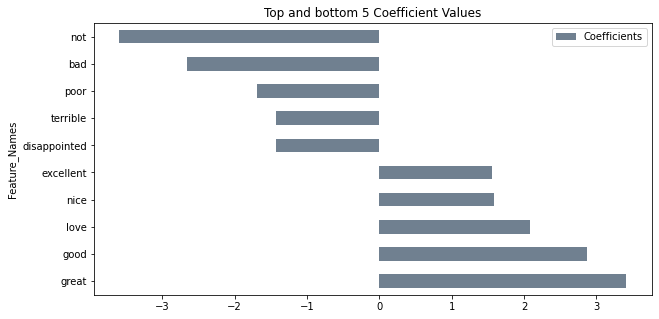

In [ ]:
best_model = model_lr.best_estimator_
coeff = best_model['LR'].coef_
features_coeff = {'Feature_Names': list(X_test_features.columns), 'Coefficients': list(coeff[0])}
feature_importance = pd.DataFrame(data=features_coeff)

top_5 = feature_importance.sort_values(by=['Coefficients'], ascending=False).head(5)
bottom_5 = feature_importance.sort_values(by=['Coefficients'], ascending=False).tail(5)

import matplotlib.pyplot as plt
d = pd.concat([top_5, bottom_5], axis=0)
d.plot.barh(x="Feature_Names",y="Coefficients", color='slategray', figsize = (10,5))
plt.title("Top and bottom 5 Coefficient Values")
plt.show()

# Selecting 5 random misclassfied examples for analysis

In [ ]:
## Select 5 random incorrect predictions
df_test['Prediction'] = y_pred
df_test['Probablity'] = y_probablity
filter = df_test['Prediction'] != df_test['Polarity']
df_test.where(filter, inplace=True)
incorrect_pred = df_test.dropna().sample(5, random_state = 22)
incorrect_pred

,Sentence,Polarity,clean_sentence,Prediction,Probablity
510,I highly doubt that anyone could ever like thi...,0.0,i highly doubt that anyone could ever like thi...,1.0,0.560196
271,Raw and sublimely moving.,1.0,raw and sublimely move,0.0,0.405271
417,You will leave the theater wanting to go out a...,1.0,-PRON- will leave the theater want to go out a...,0.0,0.433548
154,It's a shame to see good actors like Thomerson...,0.0,-PRON- a shame to see good actor like thomerso...,1.0,0.756953
581,I keep watching it over and over.,1.0,i keep watch -PRON- over and over,0.0,0.419946


**Example 1**:  *true is 0,  prediction is 1*




In [ ]:
# Print the Sentence and cleaned sentence of Example 1
print(f"Sentence: {incorrect_pred.iloc[0,0]}")
print(f"\nCleaned Sentence: {incorrect_pred.iloc[0,2]}")

# Get the feature coefficient values of the tokens and ngrams of the sentence
txt = incorrect_pred.iloc[0,2].replace("-PRON-", "pron")
tokens = txt.split()
tri_grams = [" ".join(items) for items in list(ngrams(tokens, 3))]
bi_grams = [" ".join(items) for items in list(ngrams(tokens, 2))]
q1 = feature_importance.query(f'Feature_Names in  {tokens}')
q2 = feature_importance.query(f'Feature_Names in  {tri_grams}')
q3 = feature_importance.query(f'Feature_Names in  {bi_grams}')

print(f"\n\n{pd.concat([q1,q2,q3]).reset_index(drop=True)}")

Sentence: I highly doubt that anyone could ever like this trash.  

Cleaned Sentence: i highly doubt that anyone could ever like this trash


  Feature_Names  Coefficients
0        anyone      0.210849
1         could      0.080199
2          ever     -0.341351
3        highly      0.137826
4          like      0.390760
5         trash     -0.285516


- The Coefficient of the word 'like' is dominating and is pulling the prediction to 1 along with other words positive words 'anyone' and 'highly'.

- Although, the model has learned the word 'trash' correctly with a negative coefficient. The overall weightage of words with positive coefficients is more and making the model predict incorrectly.

**Example 2**: *true is 1,  prediction is 0*


In [ ]:
# Print the Sentence and cleaned sentence of Example 1
print(f"Sentence: {incorrect_pred.iloc[1,0]}")
print(f"\nClean Sentence: {incorrect_pred.iloc[1,2]}")

# Get the feature coefficient values of the tokens and ngrams of the sentence
txt = incorrect_pred.iloc[1,2].replace("-PRON-", "pron")
tokens = txt.split()
tri_grams = [" ".join(items) for items in list(ngrams(tokens, 3))]
bi_grams = [" ".join(items) for items in list(ngrams(tokens, 2))]
q1 = feature_importance.query(f'Feature_Names in  {tokens}')
q2 = feature_importance.query(f'Feature_Names in  {tri_grams}')
q3 = feature_importance.query(f'Feature_Names in  {bi_grams}')
print(f"\n\n{pd.concat([q1,q2,q3]).reset_index(drop=True)}")

Sentence: Raw and sublimely moving.  

Clean Sentence: raw and sublimely move


  Feature_Names  Coefficients
0          move     -0.269988


- The word 'move' has a negative Coefficient, and thus the model is predicting '0' .

- The crucial words 'raw' and 'sublimely' are not present in the Train set. (See below)

In [ ]:
# Find out the word frequency of th word 'standdout' in Train set and 'scene
print(f"DF of 'raw' in Train:{sum(df_train['clean_sentence'].apply(lambda x:True if' raw 'in x else False))}")
print(f"\nDF of 'sublimely' in Train:{sum(df_train['clean_sentence'].apply(lambda x:True if' sublimely 'in x else False))}")

DF of 'raw' in Train:0

DF of 'sublimely' in Train:0


**Example 3**:  *true is 1,  prediction is 0*

In [ ]:
# Print the Sentence and cleaned sentence of Example 1
print(f"Sentence: {incorrect_pred.iloc[2,0]}")
print(f"\nClean Sentence: {incorrect_pred.iloc[2,2]}")

# Get the feature coefficient values of the tokens and ngrams of the sentence
txt = incorrect_pred.iloc[2,2].replace("-PRON-", "pron")
tokens = txt.split()
tri_grams = [" ".join(items) for items in list(ngrams(tokens, 3))]
bi_grams = [" ".join(items) for items in list(ngrams(tokens, 2))]
q1 = feature_importance.query(f'Feature_Names in  {tokens}')
q2 = feature_importance.query(f'Feature_Names in  {tri_grams}')
q3 = feature_importance.query(f'Feature_Names in  {bi_grams}')
print(f"\n\n{pd.concat([q1,q2,q3]).reset_index(drop=True)}")

Sentence: You will leave the theater wanting to go out and dance under the stars.  

Clean Sentence: -PRON- will leave the theater want to go out and dance under the star


  Feature_Names  Coefficients
0            go     -0.274081
1         leave     -0.496006
2          star      0.047943
3       theater     -0.087853
4          want      0.159297


- This example has negative words such as 'leave' and 'go' with high negative coefficients.

- The meaning of the sentence is difficult to understand for a model. Even though most of the words have a 'negative' sentiment to them, when used correctly, the overall sentence has a positive sentiment.

**Example 4** :   *true is 0,  prediction is 1*


In [ ]:
# Print the Sentence and cleaned sentence of Example 1
print(f"Sentence: {incorrect_pred.iloc[3,0]}")
print(f"\nCleaned Sentence: {incorrect_pred.iloc[3,2]}")

# Get the feature coefficient values of the tokens and ngrams of the sentence
txt = incorrect_pred.iloc[3,2].replace("-PRON-", "pron")
tokens = txt.split()
tri_grams = [" ".join(items) for items in list(ngrams(tokens, 3))]
bi_grams = [" ".join(items) for items in list(ngrams(tokens, 2))]
q1 = feature_importance.query(f'Feature_Names in  {tokens}')
q2 = feature_importance.query(f'Feature_Names in  {tri_grams}')
q3 = feature_importance.query(f'Feature_Names in  {bi_grams}')
print(f"\n\n{pd.concat([q1,q2,q3]).reset_index(drop=True)}")

Sentence: It's a shame to see good actors like Thomerson and James make a living in a mess like this.  

Cleaned Sentence: -PRON- a shame to see good actor like thomerson and james make a living in a mess like this


  Feature_Names  Coefficients
0         actor      0.096411
1          good      2.876354
2          like      0.390760
3          make      0.078229
4          mess      0.002378
5           see     -0.098336


- In this example, the model's prediction is dominated by the words 'good' and 'like'. 

- The negative term 'shame', which is changing the whole meaning to negative sentiment, is not present in the features as the word 'shame' was not present in Train data (see below).

In [ ]:
print(f"DF of 'shame' in Train: {sum(df_train['clean_sentence'].apply(lambda x:True if' shame 'in x else False))}")

DF of 'shame' in Train: 0


**Example 5** : *true is 1,  prediction is 0*



In [ ]:
# Print the Sentence and cleaned sentence of Example 1
print(f"Sentence: {incorrect_pred.iloc[4,0]}")
print(f"\nCleaned Sentence: {incorrect_pred.iloc[4,2]}")

# Get the feature coefficient values of the tokens and ngrams of the sentence
txt = incorrect_pred.iloc[4,2].replace("-PRON-", "pron")
tokens = txt.split()
tri_grams = [" ".join(items) for items in list(ngrams(tokens, 3))]
bi_grams = [" ".join(items) for items in list(ngrams(tokens, 2))]
q1 = feature_importance.query(f'Feature_Names in  {tokens}')
q2 = feature_importance.query(f'Feature_Names in  {tri_grams}')
q3 = feature_importance.query(f'Feature_Names in  {bi_grams}')
print(f"\n\n{pd.concat([q1,q2,q3]).reset_index(drop=True)}")

Sentence: I keep watching it over and over.  

Cleaned Sentence: i keep watch -PRON- over and over


  Feature_Names  Coefficients
0          keep     -0.327439
1         watch     -0.059905
2    watch pron      0.017602


- In this example, the word 'keep' is dominating and has a negative coefficient.
- The word 'keep' has a neutral sentiment, but the model has learned high negative weights. More training data would help model correct such errors.

